## Problem definition and data description

### Problem Definition
Our company (Spotify) would like to dynamically target advertising to non-premium members based on their physical activity while using Spotify services. For example, while a listener is enjoying a podcast and folding their laundry, they would receive an ad for laundry detergent. 

In addition Spotify also wishes to cater to our premium members by enhancing music recommendation/auto-play options based on a members physical activity. For example, while a user is exercising play up-tempo music, and while a user is eating pasta play Italian classics.

### Data Description

Accelerometer (measures proper acceleration) and Gyroscope (measures orientation and angular velocity) data was collected from 51 volunteer subjects. Each subject was asked to perform 18 tasks for 3 minutes each. The 18 tasks were a mix of physical activities that could be distinctly identified, such as walking, eating, laundry, etc. We (Spotify) tried to collect data for activities that our members might be doing while using our services. The tasks are listed below.

![image info](./images/Activity-Code-Table.png)

Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket. The smartphone and smartwatch both had an accelerometer and gyrocope, yielding four total sensors (Phone - Gyroscope, Phone - Accelerometer, Watch - Gyroscope, Watch - Accelerometer).

![image info](./images/Human-With-Sensors.png)

To accomodate the four sensors, the data is split up into 4 subdirectories, one for each device and sensor. 

![image info](./images/Sensor-Subdirectories.png)

Each directory contains the sensor results for the 51 subject's performance of the 18 activities. The results for each subject are stored in a comma delimited text file. Since there are 51 subjects and 4 different sensors, there are a total of 204 text files. Each text file has the same six attributes: Subject-id, Activity Code, Timestamp, x, y, z

![image info](./images/Raw-Data-Description.png)

## Data preparation process

Our data is pretty clean, we don't need to do a lot of preproccessing/data engineering. We really just need to do the ML side, which, lends itself more to the majority of work we need to do with this project. We stuck with dask so we could use the natural integration it has with python, as well as its similiar syntax to Pandas.

To clean, prepare and train our data, we decided to go with dask. Our reasoning was that, while our data was large (approx. 15 million records, ~1 gb), it was not large enough to warrant the use of Spark. The image below summarizes our thoughts on the choice between dask vs spark.

![image info](./images/Pandas-Dask-Spark-Compare.png)

### Importing the data

To shortstep the inconvenience of downloading and importing over 200 text files, we decided to host all the data on github for easy access (https://github.com/gojandrooo/DSE-230/tree/main/data). To quickly pull the github data into a pandas dataframe, we defined a function collate_df that will pull in all data matching the parameters given.

Begin by importing all the necessary libraries

Running within *Docker* container you will need to install libraries not already included in the image.
- comment/uncomment the `%pip install` cell (below)
- run the cell, wait for the packages to install, and then restart notebook. 
- once installs are complete, comment out the cell and run all

In [1]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
#set a random state seed for replication
seed=23

In [3]:
# standard libraries
import os
import pandas as pd
import numpy as np
#import itertools as it

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# distributed libraries
import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
from dask import delayed
import joblib

# model processing libraries
#import dask_distance
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
#from sklearn.model_selection import GridSearchCV
import dask_ml.model_selection as dcv

# models
# will need to update these with the models we use
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

import ssl
# needed to request files from GitHub when running within docker container
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# Start and connect to a local dask.distributed client
client = Client(processes=True) # use all 4 cores
client.connection_args

{'ssl_context': None, 'require_encryption': False, 'extra_conn_args': {}}

Get data from github and prep files for analysis

In [5]:
# key for understanding which activity is being measured in a record
activity_key_url = r"https://raw.githubusercontent.com/gojandrooo/DSE-230/main/data/activity_key.txt"

#read the activity table from gtihub
activity_key = pd.read_csv(activity_key_url, header=None)

#split the data into a proper table
activity_key = activity_key[0].str.replace(" ", "").str.split("=", expand=True)
activity_key.columns = ['activity', 'code']

In [6]:
# #do not run unless you need cleaned parquet files locally
# #cleaned parquet files should already be located on github

# #below function takes the raw data on githup and converts to parquet files
# #then stores the files on local machine
# '''
# def convert_raw_to_parquet():
#     #base URL where raw data can be easly grabbed
#     base_url = r"https://raw.githubusercontent.com/gojandrooo/DSE-230/main/data"

#     # TOGGLE FOR DEVICE
#     devices = ["phone", "watch"]

#     # TOGGLE FOR MEASUREMENT TYPE
#     data_types = ["accel", "gyro"]
    
    
#     # create list of local folders
#     for data_type in data_types:
#         for device in devices:
#             os.makedirs(r"data/parquet/" + "/" + device + "/" + data_type, exist_ok=True) 
    

#     locs = {}
#     for data_type in data_types:
#         for device in devices:
#             file_locs = []
#             for user_id in range(1600, 1651):
#                 url = base_url + "/" + device + "/" + data_type + f"/data_{user_id}_{data_type}_{device}.txt"
#                 df = pd.read_csv(url, header=None)
#                 df.columns = ['subject_id', 'code', 'timestamp', 'x', 'y', 'z']
#                 custom_dtypes = {"subject_id": "int16", "x": "float32", "y": "float32", "z": "float32"}
#                 df['z'] = df['z'].str.replace(";", "")
#                 #df = df.reset_index(drop = True)
#                 df = df.astype(custom_dtypes)
#                 df['index'] = df['subject_id'].astype('str') + df['code'] + df['timestamp'].astype('str')
#                 fname = r"data/parquet/" + "/" + device + "/" + data_type + f"/data_{user_id}_{data_type}_{device}.gzip"
#                 df.to_parquet(fname)
#                 file_locs.append(fname)
#             locs[device, data_type] = file_locs
# '''

In [7]:
# NOTE
# this still only grabs three spreadsheets, update for production

# dask_df = dd.read_parquet('./data/parquet/phone/accel/data_1600_accel_phone.gzip', index = 'index')
def collate_dask_df(device, data_type):

    '''
    returns a single dask dataframe from multiple text files hosted on github
    
    device: ["phone", "watch"]
    
    data_type: ["accel", "gyro"]
    ----------------------------
    '''
    
    base_url = './data/parquet'

    # TOGGLE FOR DEVICE
    device = device

    # TOGGLE FOR MEASUREMENT TYPE
    data_type = data_type
    
    # create list of all file names
    file_names = [f"/data_{user_id}_{data_type}_{device}.gzip" for user_id in range(1600, 1651)]

    # create urls of all files
    loop_urls = [base_url + "/" + device + "/" + data_type + file_name for file_name in file_names]
    
    #import the data
    dask_df = dd.read_parquet(loop_urls, index = 'index') # PRODUCTION, all of the files

   # dask df output 
    return dask_df 

### Importing the data

In [8]:
#get link to client dashboard
client.dashboard_link

'http://127.0.0.1:8787/status'

In [9]:
%%time
dd_ref = {
    'phone_accel': collate_dask_df("phone", "accel"),
    'phone_gyro': collate_dask_df("phone", "gyro"),
    'watch_accel': collate_dask_df("watch", "accel"),
    'watch_gyro': collate_dask_df("watch", "gyro")
}

print(pd.DataFrame({
    'dd': [k for k in dd_ref.keys()],
    'rows': [dd.shape[0].compute() for dd in dd_ref.values()],
    'columns': [dd.shape[1] for dd in dd_ref.values()]
}))

            dd     rows  columns
0  phone_accel  4804403        6
1   phone_gyro  3608635        6
2  watch_accel  3777046        6
3   watch_gyro  3440342        6
CPU times: user 2.49 s, sys: 551 ms, total: 3.04 s
Wall time: 8.78 s


In [10]:
%%time
for k, v_dd in dd_ref.items():
    # create linear combinations of the axes
    dd_ref[k] = v_dd.assign(
        xy = v_dd['x'] * v_dd['y'],
        yz = v_dd['y'] * v_dd['z'],
        xz = v_dd['x'] * v_dd['z'],
        x2 = v_dd['x']**2,
        y2 = v_dd['y']**2,
        z2 = v_dd['z']**2
    )
    
print(pd.DataFrame({
    'dd': [k for k in dd_ref.keys()],
    'rows': [dd.shape[0].compute() for dd in dd_ref.values()],
    'columns': [dd.shape[1] for dd in dd_ref.values()]
}))

            dd     rows  columns
0  phone_accel  4804403       12
1   phone_gyro  3608635       12
2  watch_accel  3777046       12
3   watch_gyro  3440342       12
CPU times: user 6.87 s, sys: 604 ms, total: 7.48 s
Wall time: 10.2 s


### Merge files based on index

In [11]:
#define columns for left df so we don't get unecessary duplicate columns 
feat_cols = ['x', 'y', 'z', 'xy', 'yz', 'xz', 'x2', 'y2', 'z2']

#merge the device files (eg phone accel and phone gyro/watch accel and watch gyro)
def merge_dfs(df1, df2, suffixes):
    df1partitions = df1.npartitions
    df2partitions = df2.npartitions
    partitions = min(df1partitions, df2partitions)
    merged =  dd.merge(
        df1, df2[feat_cols], how='inner', left_index=True, right_index=True, suffixes=suffixes
    ).reset_index(drop = True)
    return dd.from_pandas(merged.compute(), npartitions = partitions)

In [12]:
#define a dictionary for keeping track of the before and after shapes
shape_ref = {}

In [13]:
%%time
#combine phone data frame using function above
phone_df = merge_dfs(dd_ref['phone_accel'], dd_ref['phone_gyro'][feat_cols], ('_phone_accel', '_phone_gyro'))

#record the shape of the merged data
shape_ref['phone_df'] = len(phone_df)

#remove the individual data frames from memory
client.cancel(dd_ref['phone_accel'])
client.cancel(dd_ref['phone_gyro'])

CPU times: user 8.53 s, sys: 1.76 s, total: 10.3 s
Wall time: 25.4 s


In [14]:
%%time
#combine phone data frame using function above
watch_df = merge_dfs(dd_ref['watch_accel'], dd_ref['watch_gyro'][feat_cols], ('_watch_accel', '_watch_gyro'))

#record the shape of the merged data
shape_ref['watch_df'] = len(watch_df)

#remove the individual data frames from memory
client.cancel(dd_ref['watch_accel'])
client.cancel(dd_ref['watch_gyro'])

CPU times: user 9 s, sys: 1.56 s, total: 10.6 s
Wall time: 22.6 s


In [15]:
#free up some memory
del dd_ref

### Grouping the data into 3 second intervals
Since every recording is ~ 50 ms (1/1000 second) we thought it would be good to aggregate the data into seconds

In [16]:
# takes the combined sensor data and bins the data by taking the average depending on the seconds required

def group_into_seconds(df, num_seconds):
    
    # calculates the number of rows to average over by computing  num_seconds in ms and diving by 50 (sensor interval)
    n_rows = (num_seconds*1000)/50
    print('Grouped every', n_rows, 'rows')
    
    #reset the index twice to clear out any weird grouping logic
    tempdf = df.reset_index(drop=True).reset_index()
    
    # rename of the index column
    tempdf = tempdf.rename(columns= {'index': 'grouper'})
    
    # creates a variable to group within n_seconds
    tempdf['grouper'] = tempdf['grouper']//n_rows
    
    # aggregate to n_seconds
    tempdf = tempdf.groupby(by = ['grouper', 'code', 'subject_id']).agg(['mean', 'sum']).reset_index()
    # drop superflous grouper column
    del tempdf['grouper']
    
    return tempdf
    # return df.groupby(np.arange(len(df))//n_rows).mean().compute()


In [17]:
#just testing to make sure it returns the same exact data frame when growing rows = 1
#group_into_seconds(phone_df.compute(),50/1000)

In [18]:
agg_time = 3

#define a new df for the phone by rolling up the observations into agg_time second intervals
grouped_phone_df = group_into_seconds(phone_df.compute(),agg_time)

#record the shape of the grouped data
shape_ref['grouped_phone_df'] = len(grouped_phone_df)

#remove the individual data frames from memory
client.cancel(phone_df)
del phone_df

#define a new df for the watch by rolling up the observations into agg_time second intervals
grouped_watch_df = group_into_seconds(watch_df.compute(),agg_time)

#record the shape of the grouped data
shape_ref['grouped_watch_df'] = len(grouped_watch_df)

#remove the individual data frames from memory
client.cancel(watch_df)
del watch_df

Grouped every 60.0 rows
Grouped every 60.0 rows


In [19]:
#flatten out multi index
grouped_phone_df.columns = list(map(''.join, grouped_phone_df.columns.values))
grouped_watch_df.columns = list(map(''.join, grouped_watch_df.columns.values))

In [20]:
grouped_phone_df.head()

,code,subject_id,timestampmean,timestampsum,x_phone_accelmean,x_phone_accelsum,y_phone_accelmean,y_phone_accelsum,z_phone_accelmean,z_phone_accelsum,...,yz_phone_gyromean,yz_phone_gyrosum,xz_phone_gyromean,xz_phone_gyrosum,x2_phone_gyromean,x2_phone_gyrosum,y2_phone_gyromean,y2_phone_gyrosum,z2_phone_gyromean,z2_phone_gyrosum
0,A,1600,2.522115e+14,15132688817305588,-1.088191,-65.291443,9.776991,586.619446,0.786926,47.215576,...,0.110786,6.647181,-0.008090,-0.485390,0.460516,27.630941,0.624585,37.475090,0.177609,10.656511
1,A,1600,2.522143e+14,15132859064251256,-1.182448,-70.946899,9.289057,557.343445,0.349670,20.980194,...,0.070088,4.205255,-0.011651,-0.699064,0.417917,25.075031,0.684395,41.063675,0.189320,11.359173
2,A,1600,2.522162e+14,15132971605566800,-0.962223,-57.733383,8.836941,530.216431,0.619604,37.176254,...,0.022254,1.335235,0.023129,1.387727,0.515981,30.958885,0.635198,38.111870,0.115479,6.928736
3,A,1600,2.522201e+14,15133204744704668,-1.768243,-106.094604,10.371676,622.300598,-0.198828,-11.929657,...,0.127865,7.671916,-0.015409,-0.924527,0.546038,32.762260,0.521824,31.309423,0.203901,12.234046
4,A,1600,2.522213e+14,15133280628253460,-1.619576,-97.174561,10.002676,600.160583,0.601288,36.077286,...,0.072089,4.325358,-0.097817,-5.868999,0.511612,30.696747,0.612733,36.763958,0.218694,13.121645


In [21]:
grouped_watch_df.head()

,code,subject_id,timestampmean,timestampsum,x_watch_accelmean,x_watch_accelsum,y_watch_accelmean,y_watch_accelsum,z_watch_accelmean,z_watch_accelsum,...,yz_watch_gyromean,yz_watch_gyrosum,xz_watch_gyromean,xz_watch_gyrosum,x2_watch_gyromean,x2_watch_gyrosum,y2_watch_gyromean,y2_watch_gyrosum,z2_watch_gyromean,z2_watch_gyrosum
0,A,1600,9.042919e+13,5425751389202750,11.053740,663.224426,-0.988267,-59.295998,1.454547,87.272842,...,2.798181,167.890839,1.148958,68.937477,2.795315,167.718903,1.408411,84.504639,10.946582,656.794922
1,A,1600,9.043241e+13,5425944666112750,12.343656,740.619385,-1.432870,-85.972191,-0.617235,-37.034111,...,5.316412,318.984711,2.254787,135.287216,3.099644,185.978653,3.292323,197.539398,18.774887,1126.493286
2,A,1600,9.043472e+13,5426083306905580,13.097301,785.838074,-1.533905,-92.034309,-0.990252,-59.415108,...,4.419897,265.193817,1.121004,67.260223,2.787872,167.272324,2.604578,156.274658,15.706801,942.408081
3,A,1600,9.043986e+13,5426391558970240,11.783632,707.017944,-1.341611,-80.496651,-1.186696,-71.201759,...,1.142224,68.533432,2.599034,155.942062,6.492970,389.578156,1.481625,88.897514,11.490375,689.422424
4,A,1600,9.044140e+13,5426483980411200,11.927145,715.628662,-1.680111,-100.806664,-1.159442,-69.566521,...,2.673024,160.381454,1.267020,76.021194,4.158214,249.492844,2.160534,129.632019,15.027987,901.679199


In [22]:
shape_ref

{'phone_df': 2909149,
 'watch_df': 3368542,
 'grouped_phone_df': 532395,
 'grouped_watch_df': 630642}

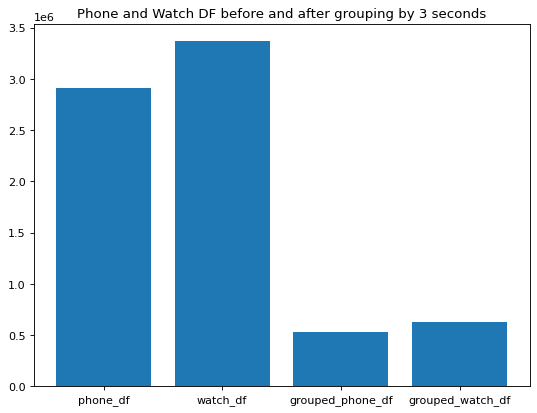

{'phone_df': 2909149, 'watch_df': 3368542, 'grouped_phone_df': 532395, 'grouped_watch_df': 630642}


In [23]:
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(shape_ref)), list(shape_ref.values()), align='center')
plt.xticks(range(len(shape_ref)), list(shape_ref.keys()))
plt.title('Phone and Watch DF before and after grouping by 3 seconds')
plt.show()
print(shape_ref)

## We are now in pandas

#### Compute Cosine Similarity between x, y, z vectors

In [24]:
# def mag_calc(arr):
#     '''magnitude of a vector'''
#     mag = np.sqrt(arr.dot(arr))
#     return mag

# def cos_sim(arr_1, arr_2):
#     '''
#     cosine similarity of two vectors
#     to calculate distance, subtract output from 1
#     '''
#     # dot product of the vectors
#     numerator = np.dot(arr_1, arr_2)
    
#     # magnitude of the vectors
#     arr_1_mag = mag_calc(arr_1)
#     arr_2_mag = mag_calc(arr_2)
    
#     denominator = arr_1_mag * arr_2_mag
    
#     cos = numerator / denominator
    
#     return cos

# # create meaningless arrays for testing
# x = np.random.randint(-5, 5, size=100)
# y = np.random.randint(-5, 5, size=100)

# cos_sim(x, y)

In [25]:
def cosine_calc(df, left_col, right_col, device, data_type):
    # denominator
    left_col_den = (left_col + "2_" + device + "_" + data_type + "sum")
    right_col_den = (right_col + "2_" + device + "_" + data_type + "sum")
    
    numerator = df[left_col + right_col + "_" + device + "_" + data_type + "sum"]
    denominator = np.sqrt(df[left_col_den] * df[right_col_den])
    
    cos = numerator / denominator
    
    return cos

In [26]:
%%time
# phone accel
grouped_phone_df['cos_xy_phone_accel'] = cosine_calc(grouped_phone_df, 'x', 'y', 'phone', 'accel')
grouped_phone_df['cos_xz_phone_accel'] = cosine_calc(grouped_phone_df, 'x', 'z', 'phone', 'accel')
grouped_phone_df['cos_yz_phone_accel'] = cosine_calc(grouped_phone_df, 'y', 'z', 'phone', 'accel')
# phone gyro
grouped_phone_df['cos_xy_phone_gyro'] = cosine_calc(grouped_phone_df, 'x', 'y', 'phone', 'gyro')
grouped_phone_df['cos_xz_phone_gyro'] = cosine_calc(grouped_phone_df, 'x', 'z', 'phone', 'gyro')
grouped_phone_df['cos_yz_phone_gyro'] = cosine_calc(grouped_phone_df, 'y', 'z', 'phone', 'gyro')

# watch accel
grouped_watch_df['cos_xy_watch_accel'] = cosine_calc(grouped_watch_df, 'x', 'y', 'watch', 'accel')
grouped_watch_df['cos_xz_watch_accel'] = cosine_calc(grouped_watch_df, 'x', 'z', 'watch', 'accel')
grouped_watch_df['cos_yz_watch_accel'] = cosine_calc(grouped_watch_df, 'y', 'z', 'watch', 'accel')
# watch gyro
grouped_watch_df['cos_xy_watch_gyro'] = cosine_calc(grouped_watch_df, 'x', 'y', 'watch', 'gyro')
grouped_watch_df['cos_xz_watch_gyro'] = cosine_calc(grouped_watch_df, 'x', 'z', 'watch', 'gyro')
grouped_watch_df['cos_yz_watch_gyro'] = cosine_calc(grouped_watch_df, 'y', 'z', 'watch', 'gyro')

CPU times: user 38.1 ms, sys: 28.8 ms, total: 66.9 ms
Wall time: 56.2 ms


In [27]:
#get rid of columns used to construct cos
grouped_phone_df = grouped_phone_df[['code', 'x_phone_accelmean', 'x_phone_accelsum', 'y_phone_accelmean',
       'y_phone_accelsum', 'z_phone_accelmean', 'z_phone_accelsum',
       'x_phone_gyromean', 'x_phone_gyrosum', 'y_phone_gyromean',
       'y_phone_gyrosum', 'z_phone_gyromean', 'z_phone_gyrosum',
       'cos_xy_phone_accel', 'cos_xz_phone_accel', 'cos_yz_phone_accel',
       'cos_xy_phone_gyro', 'cos_xz_phone_gyro', 'cos_yz_phone_gyro']]

grouped_watch_df = grouped_watch_df[['code', 'x_watch_accelmean', 'x_watch_accelsum', 'y_watch_accelmean',
       'y_watch_accelsum', 'z_watch_accelmean', 'z_watch_accelsum',
       'x_watch_gyromean', 'x_watch_gyrosum', 'y_watch_gyromean',
       'y_watch_gyrosum', 'z_watch_gyromean', 'z_watch_gyrosum',
       'cos_xy_watch_accel', 'cos_xz_watch_accel', 'cos_yz_watch_accel',
       'cos_xy_watch_gyro', 'cos_xz_watch_gyro', 'cos_yz_watch_gyro']]

In [28]:
grouped_phone_df.head()

,code,x_phone_accelmean,x_phone_accelsum,y_phone_accelmean,y_phone_accelsum,z_phone_accelmean,z_phone_accelsum,x_phone_gyromean,x_phone_gyrosum,y_phone_gyromean,y_phone_gyrosum,z_phone_gyromean,z_phone_gyrosum,cos_xy_phone_accel,cos_xz_phone_accel,cos_yz_phone_accel,cos_xy_phone_gyro,cos_xz_phone_gyro,cos_yz_phone_gyro
0,A,-1.088191,-65.291443,9.776991,586.619446,0.786926,47.215576,-0.150771,-9.046265,0.083512,5.010742,-0.035710,-2.142578,-0.567636,-0.030267,0.341594,-0.392207,-0.028287,0.332628
1,A,-1.182448,-70.946899,9.289057,557.343445,0.349670,20.980194,-0.061406,-3.684387,0.222785,13.367096,0.024281,1.456833,-0.456546,0.040798,0.065060,-0.441133,-0.041421,0.194711
2,A,-0.962223,-57.733383,8.836941,530.216431,0.619604,37.176254,0.020968,1.258057,0.227736,13.664139,0.047242,2.834549,-0.492868,0.050539,0.210506,-0.537460,0.094751,0.082168
3,A,-1.768243,-106.094604,10.371676,622.300598,-0.198828,-11.929657,0.162605,9.756317,-0.061611,-3.696671,-0.012255,-0.735275,-0.726313,0.311922,-0.186672,-0.248085,-0.046179,0.391996
4,A,-1.619576,-97.174561,10.002676,600.160583,0.601288,36.077286,0.022449,1.346924,0.154298,9.257904,0.004550,0.273026,-0.646401,0.021985,0.252195,-0.376746,-0.292431,0.196932


In [29]:
grouped_watch_df.head()

,code,x_watch_accelmean,x_watch_accelsum,y_watch_accelmean,y_watch_accelsum,z_watch_accelmean,z_watch_accelsum,x_watch_gyromean,x_watch_gyrosum,y_watch_gyromean,y_watch_gyrosum,z_watch_gyromean,z_watch_gyrosum,cos_xy_watch_accel,cos_xz_watch_accel,cos_yz_watch_accel,cos_xy_watch_gyro,cos_xz_watch_gyro,cos_yz_watch_gyro
0,A,11.053740,663.224426,-0.988267,-59.295998,1.454547,87.272842,-0.500267,-30.016029,-0.100770,-6.046201,-0.119755,-7.185278,-0.476966,0.122065,-0.305006,0.280676,0.207706,0.712643
1,A,12.343656,740.619385,-1.432870,-85.972191,-0.617235,-37.034111,-0.185540,-11.132421,-0.101503,-6.090171,-0.319535,-19.172112,-0.473731,-0.304035,-0.232638,0.099714,0.295570,0.676206
2,A,13.097301,785.838074,-1.533905,-92.034309,-0.990252,-59.415108,0.181939,10.916325,-0.035247,-2.114802,0.158339,9.500322,-0.466977,-0.386948,-0.232112,0.061849,0.169405,0.691034
3,A,11.783632,707.017944,-1.341611,-80.496651,-1.186696,-71.201759,0.361979,21.718712,-0.047745,-2.864674,-0.167495,-10.049710,-0.477756,-0.368554,-0.048467,0.017487,0.300901,0.276831
4,A,11.927145,715.628662,-1.680111,-100.806664,-1.159442,-69.566521,-0.083575,-5.014497,0.015928,0.955660,0.124208,7.452503,-0.485931,-0.470164,0.251036,-0.150073,0.160280,0.469107


## EDA

In [30]:
grouped_phone_df.describe()

,x_phone_accelmean,x_phone_accelsum,y_phone_accelmean,y_phone_accelsum,z_phone_accelmean,z_phone_accelsum,x_phone_gyromean,x_phone_gyrosum,y_phone_gyromean,y_phone_gyrosum,z_phone_gyromean,z_phone_gyrosum,cos_xy_phone_accel,cos_xz_phone_accel,cos_yz_phone_accel,cos_xy_phone_gyro,cos_xz_phone_gyro,cos_yz_phone_gyro
count,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532395.000000,532387.000000,532384.000000,532384.000000,530653.000000,529966.000000,529928.000000
mean,0.292573,1.546333,-2.338619,-5.969940,0.304107,3.426846,-0.006283,-0.032806,-0.006590,-0.033202,0.001187,-0.005361,0.036800,-0.137679,0.109068,0.032719,0.046585,0.013291
std,5.491639,37.733299,6.100018,50.771328,4.975734,37.087120,0.545923,1.968939,0.586185,2.231376,0.445670,1.582723,0.899948,0.866538,0.872006,0.733425,0.746107,0.727631
min,-78.477608,-369.721588,-71.297340,-462.250916,-45.155701,-341.672302,-17.435539,-62.100494,-20.117081,-75.549652,-29.067291,-45.321594,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-3.700305,-10.496076,-7.687040,-24.720731,-2.740164,-8.717738,-0.029178,-0.138520,-0.026898,-0.115761,-0.020062,-0.090547,-0.990502,-0.999114,-0.962906,-0.702672,-0.722691,-0.707107
50%,0.256733,0.633266,-2.795729,-7.583035,0.103995,0.268600,-0.000703,-0.002131,-0.000599,-0.001785,-0.000774,-0.002131,0.210504,-0.467720,0.434496,0.063743,0.110227,0.026048
75%,4.572277,15.641873,1.353544,3.652420,3.769344,11.771652,0.021838,0.083298,0.023914,0.089494,0.017181,0.066193,0.994610,0.942249,0.997443,0.771303,0.801859,0.736882
max,58.610920,293.694916,32.002251,626.861511,42.221802,422.166595,18.148064,40.455109,25.164001,109.892792,9.911165,47.744415,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


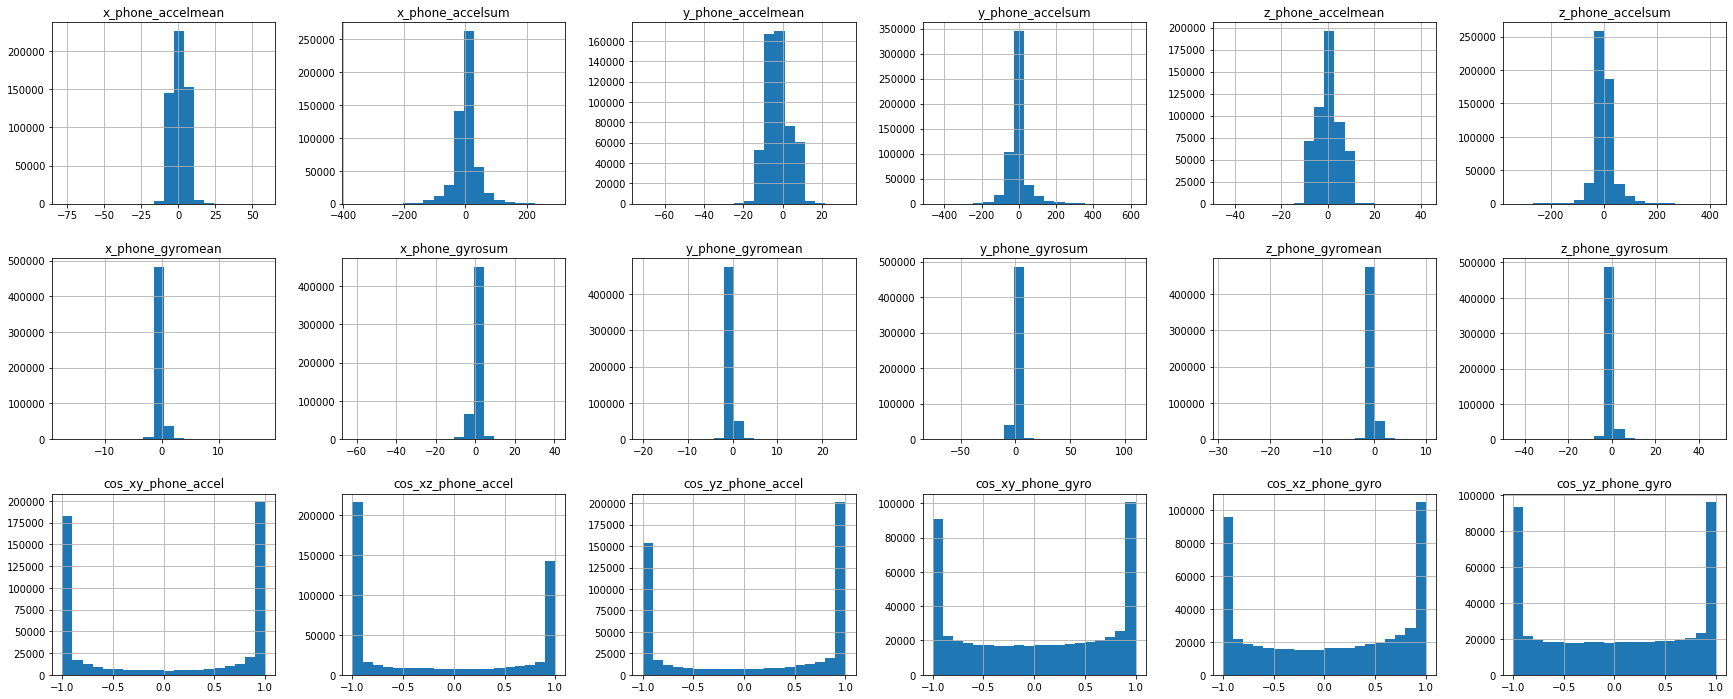

In [31]:
grouped_phone_df.hist(bins = 20, layout = (3,6), figsize=(30, 12))
plt.show()

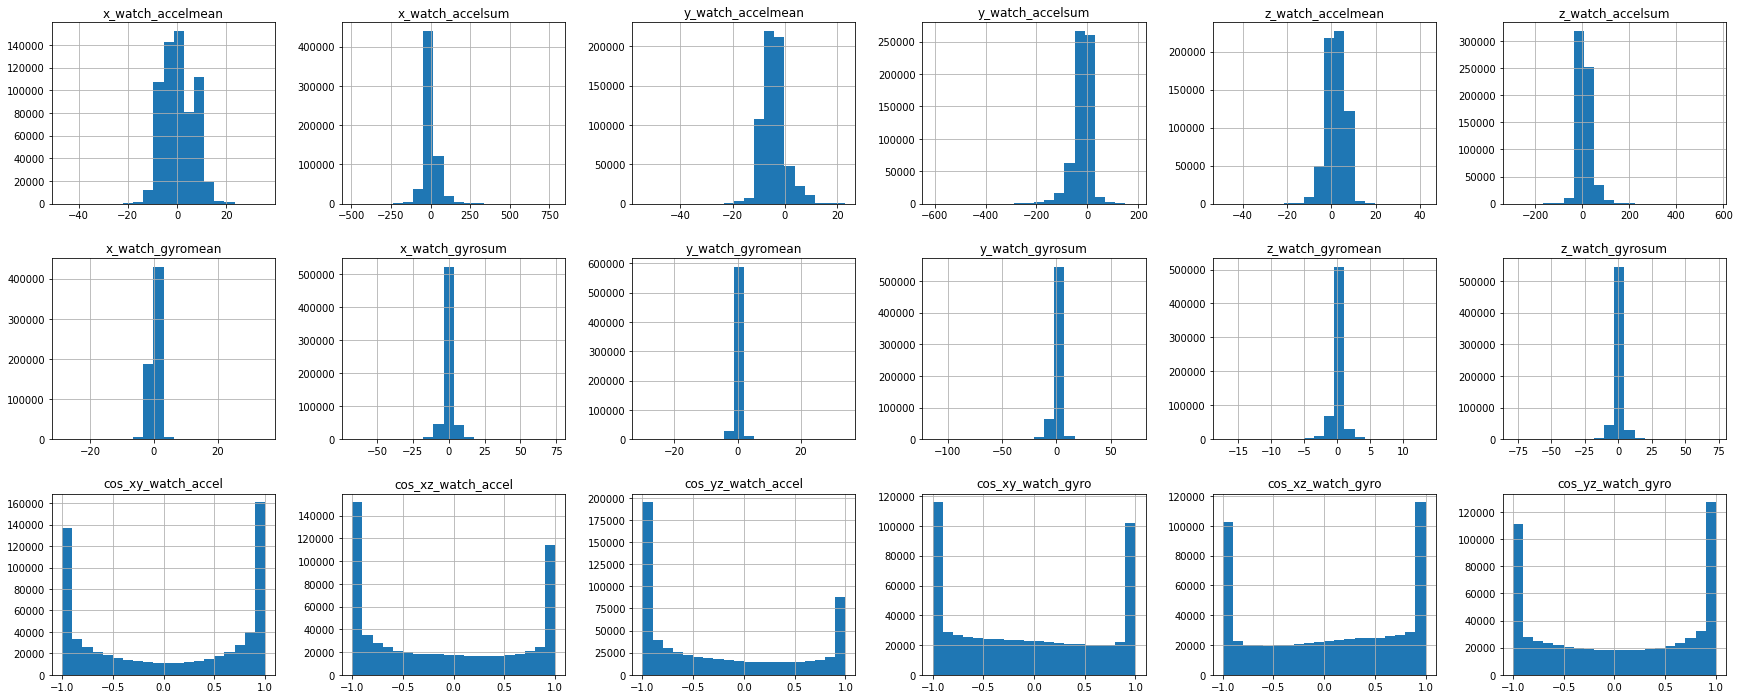

In [32]:
grouped_watch_df.hist(bins = 20, layout = (3,6), figsize=(30, 12))
plt.show()

In [33]:
# VISUALIZE DATA

# depending on your setup may need different renderer to display
# iframe should render on local implementation and docker image implementation

renderer = [
    'notebook', # local
    'notebook_connected', # local
    'kaggle', # local
    'azure', # local
    'browser', # local (opens plot in new browser tab)
    'iframe', # docker, local (saves plot in `iframe_figures` folder)
    'iframe_connected', # docker, local (saves plot in `iframe_figures` folder)
    'colab' # docker
]

# phone accelerometer
# take a sample of the data
df = grouped_phone_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='x_phone_accelsum', 
                    y='y_phone_accelsum', 
                    z='z_phone_accelsum',
                    color = 'code',
                    title='Phone Accelerometer'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [34]:
# phone gyroscope

# take a sample of the data
df = grouped_phone_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='x_phone_gyrosum', 
                    y='y_phone_gyrosum', 
                    z='x_phone_gyrosum',
                    color = 'code',
                    title='Phone Gyroscope'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [35]:
# watch accelerometer

# take a sample of the data
df = grouped_watch_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='x_watch_accelsum', 
                    y='y_watch_accelsum', 
                    z='z_watch_accelsum',
                    color = 'code',
                    title='Watch Accelerometer'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [36]:
# watch gyroscope

# take a sample of the data
df = grouped_watch_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='x_watch_gyrosum', 
                    y='y_watch_gyrosum', 
                    z='z_watch_gyrosum',
                    color = 'code',
                    title='Watch Gyroscope'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [37]:
# # phone accel cosine

# take a sample of the data
df = grouped_phone_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='cos_xy_phone_accel', 
                    y='cos_xz_phone_accel', 
                    z='cos_yz_phone_accel',
                    color = 'code',
                    title='Phone Accelerometer - Cosine Similarity'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [38]:
# # phone gyro cosine

# take a sample of the data
df = grouped_phone_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='cos_xy_phone_gyro', 
                    y='cos_xz_phone_gyro', 
                    z='cos_yz_phone_gyro',
                    color = 'code',
                    title='Phone Gyroscope - Cosine Similarity'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [39]:
# # watch accel cosine

# take a sample of the data
df = grouped_watch_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='cos_xy_watch_accel', 
                    y='cos_xz_watch_accel', 
                    z='cos_yz_watch_accel',
                    color = 'code',
                    title='Watch Accelerometer - Cosine Similarity'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

In [41]:
# # watch gyro cosine

# take a sample of the data
df = grouped_watch_df.sample(frac=0.3, random_state=seed).sort_values(by='code')
fig = px.scatter_3d(df, 
                    x='cos_xy_watch_gyro', 
                    y='cos_xz_watch_gyro', 
                    z='cos_yz_watch_gyro',
                    color = 'code' ,
                    title='Watch Gyroscope - Cosine Similarity'
                   )
fig.update_layout(height=1000)
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

- Use PySpark or Dask
- Include one classificationorregressionorclusteranalysis task
- Describe problem
    - To include:  Explain why problem is interesting, what real-life application is being addressed
- Describe analysis task
    - To include:  type of task (e.g., classification), how does task related to business problem
- Describe data
    - To include:  data quality issues, characteristics of the dataset (summary statistics,
correlation, outliers, etc.), plots
- Describe data preparation process
    - To include:  data cleaning steps, features used, train/validation/test datasets
- Describe analysis approaches
    - To include:  input, setup, and output of model(s)
- Describe challenges and solutions
    - To include:  challenges encountered, solutions to address challenges
- Describe analysis results and insights gained
    - To include:  discussion of results, insights gained from analysis
- Describe future work
    - To include:  lessons learned, next steps, what you would have done differently




Measures movement data over ten-second
intervals while subjects perform the various tasks.

## Analysis approaches

### Model Selection

<font color='red'>this section is wildly incomplete</font>

[**sklearn - Decision Tree Regression with AdaBoost**](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html)

[https://examples.dask.org/machine-learning.html](https://examples.dask.org/machine-learning.html)

In [34]:
grouped_phone_df.head()

,code,x_phone_accelmean,x_phone_accelsum,y_phone_accelmean,y_phone_accelsum,z_phone_accelmean,z_phone_accelsum,x_phone_gyromean,x_phone_gyrosum,y_phone_gyromean,y_phone_gyrosum,z_phone_gyromean,z_phone_gyrosum,cos_xy_phone_accel,cos_xz_phone_accel,cos_yz_phone_accel,cos_xy_phone_gyro,cos_xz_phone_gyro,cos_yz_phone_gyro
0,A,-1.088191,-65.291443,9.776991,586.619446,0.786926,47.215576,-0.150771,-9.046265,0.083512,5.010742,-0.035710,-2.142578,-0.567636,-0.030267,0.341594,-0.392207,-0.028287,0.332628
1,A,-1.182448,-70.946899,9.289057,557.343445,0.349670,20.980194,-0.061406,-3.684387,0.222785,13.367096,0.024281,1.456833,-0.456546,0.040798,0.065060,-0.441133,-0.041421,0.194711
2,A,-0.962223,-57.733383,8.836941,530.216431,0.619604,37.176254,0.020968,1.258057,0.227736,13.664139,0.047242,2.834549,-0.492868,0.050539,0.210506,-0.537460,0.094751,0.082168
3,A,-1.768243,-106.094604,10.371676,622.300598,-0.198828,-11.929657,0.162605,9.756317,-0.061611,-3.696671,-0.012255,-0.735275,-0.726313,0.311922,-0.186672,-0.248085,-0.046179,0.391996
4,A,-1.619576,-97.174561,10.002676,600.160583,0.601288,36.077286,0.022449,1.346924,0.154298,9.257904,0.004550,0.273026,-0.646401,0.021985,0.252195,-0.376746,-0.292431,0.196932


[You should aim for partitions that have around 100MB of data each.](https://docs.dask.org/en/stable/dataframe-best-practices.html)
- each of these dataframes is 130MB - 160MB

- Use a Categorical for efficient storage of an object-dtype column with many repeated values.
```python
>>> df['object'].astype('category').memory_usage(deep=True)
5244
```

In [35]:
grouped_phone_df['code'].memory_usage(deep=True) / 1_000_000

30.879038

In [36]:
grouped_phone_df['code'].astype('category').memory_usage(deep=True) / 1_000_000

0.534123

In [37]:
grouped_watch_df['code'].memory_usage(deep=True) / 1_000_000

36.577364

In [38]:
grouped_watch_df['code'].astype('category').memory_usage(deep=True) / 1_000_000

0.63237

In [39]:
#grouped_phone_df.info(memory_usage='deep')
grouped_phone_df.memory_usage(deep=True).sum() / 1_000_000

69.211478

In [40]:
#grouped_watch_df.info(memory_usage='deep')
grouped_watch_df.memory_usage(deep=True).sum() / 1_000_000

81.983588

In [41]:
# achieve some memory savings
'''
we should get this into the parquet schema or convert as early as possible
'''
grouped_phone_df['code'] = grouped_phone_df['code'].astype('category')
grouped_watch_df['code'] = grouped_watch_df['code'].astype('category')

In [42]:
# it worked :)
#grouped_phone_df.info(memory_usage='deep')
grouped_phone_df.memory_usage(deep=True).sum() / 1_000_000

38.866563

In [43]:
# it worked :)
#grouped_watch_df.info(memory_usage='deep')
grouped_watch_df.memory_usage(deep=True).sum() / 1_000_000

46.038594

### now train test split

In [44]:
feat_cols = [col for col in grouped_phone_df][1:] # this slicing could change later
feat_cols

['x_phone_accelmean',
 'x_phone_accelsum',
 'y_phone_accelmean',
 'y_phone_accelsum',
 'z_phone_accelmean',
 'z_phone_accelsum',
 'x_phone_gyromean',
 'x_phone_gyrosum',
 'y_phone_gyromean',
 'y_phone_gyrosum',
 'z_phone_gyromean',
 'z_phone_gyrosum',
 'cos_xy_phone_accel',
 'cos_xz_phone_accel',
 'cos_yz_phone_accel',
 'cos_xy_phone_gyro',
 'cos_xz_phone_gyro',
 'cos_yz_phone_gyro']

In [45]:
grouped_phone_df_x = grouped_phone_df[feat_cols]
grouped_phone_df_y = grouped_phone_df['code']

In [46]:
feat_cols = [col for col in grouped_watch_df][1:] # this slicing could change later
feat_cols

['x_watch_accelmean',
 'x_watch_accelsum',
 'y_watch_accelmean',
 'y_watch_accelsum',
 'z_watch_accelmean',
 'z_watch_accelsum',
 'x_watch_gyromean',
 'x_watch_gyrosum',
 'y_watch_gyromean',
 'y_watch_gyrosum',
 'z_watch_gyromean',
 'z_watch_gyrosum',
 'cos_xy_watch_accel',
 'cos_xz_watch_accel',
 'cos_yz_watch_accel',
 'cos_xy_watch_gyro',
 'cos_xz_watch_gyro',
 'cos_yz_watch_gyro']

In [47]:
grouped_watch_df_x = grouped_watch_df[feat_cols]
grouped_watch_df_y = grouped_watch_df['code']

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
phone_x_train, phone_x_test, phone_y_train, phone_y_test = train_test_split(
    grouped_phone_df_x, grouped_phone_df_y, test_size=0.33, random_state=seed)

In [50]:
watch_x_train, watch_x_test, watch_y_train, watch_y_test = train_test_split(
    grouped_watch_df_x, grouped_watch_df_y, test_size=0.33, random_state=seed)

In [51]:
phone_x_train.fillna(0, inplace=True)
phone_x_test.fillna(0, inplace=True)
watch_x_train.fillna(0, inplace=True)
watch_x_test.fillna(0, inplace=True)

### Scale the data

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(phone_x_train)
phone_x_train = scaler.transform(phone_x_train)
phone_x_test  = scaler.transform(phone_x_test)

scaler = StandardScaler()
scaler.fit(watch_x_train)
watch_x_train = scaler.transform(watch_x_train)
watch_x_test  = scaler.transform(watch_x_test)

In [53]:
from sklearn.metrics import confusion_matrix

### Logistic Regression

In [200]:
from sklearn.linear_model import LogisticRegression

In [201]:
%%time
clf = LogisticRegression(random_state=seed)
clf.fit(phone_x_train, phone_y_train)

CPU times: user 14.6 s, sys: 11.4 s, total: 26 s
Wall time: 6.22 s


LogisticRegression(random_state=23)

In [202]:
%%time
clf.score(phone_x_test, phone_y_test)

CPU times: user 435 ms, sys: 418 ms, total: 853 ms
Wall time: 174 ms


0.11350609877569141

In [203]:
predictions = clf.predict(phone_x_test)

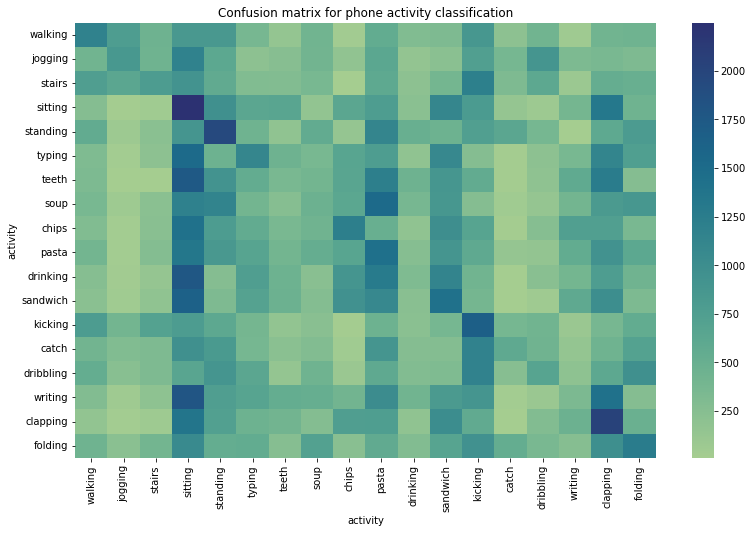

In [204]:
results = pd.DataFrame(confusion_matrix(phone_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

In [205]:
%%time
clf = LogisticRegression(random_state=seed)
clf.fit(watch_x_train, watch_y_train)

CPU times: user 29.5 s, sys: 22 s, total: 51.5 s
Wall time: 12.3 s


LogisticRegression(random_state=23)

In [206]:
%%time
clf.score(watch_x_test, watch_y_test)

CPU times: user 480 ms, sys: 420 ms, total: 901 ms
Wall time: 201 ms


0.29865168755285615

In [207]:
predictions = clf.predict(watch_x_test)

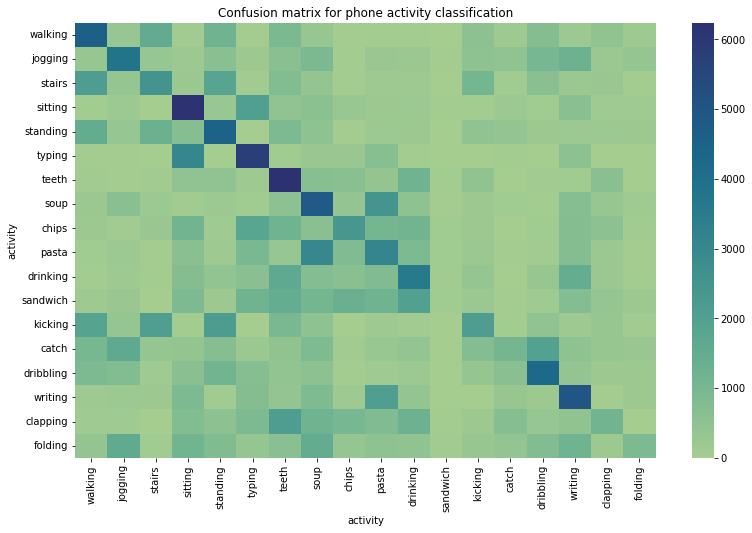

In [208]:
results = pd.DataFrame(confusion_matrix(watch_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

### KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
%%time
knn = KNeighborsClassifier(n_neighbors = 18, n_jobs = -1)
knn.fit(phone_x_train, phone_y_train)

CPU times: user 284 ms, sys: 1.2 ms, total: 285 ms
Wall time: 273 ms


KNeighborsClassifier(n_jobs=-1, n_neighbors=18)

In [141]:
%%time
knn.score(phone_x_test, phone_y_test)

CPU times: user 34min 8s, sys: 23min 44s, total: 57min 53s
Wall time: 19min 53s


0.5639958791286975

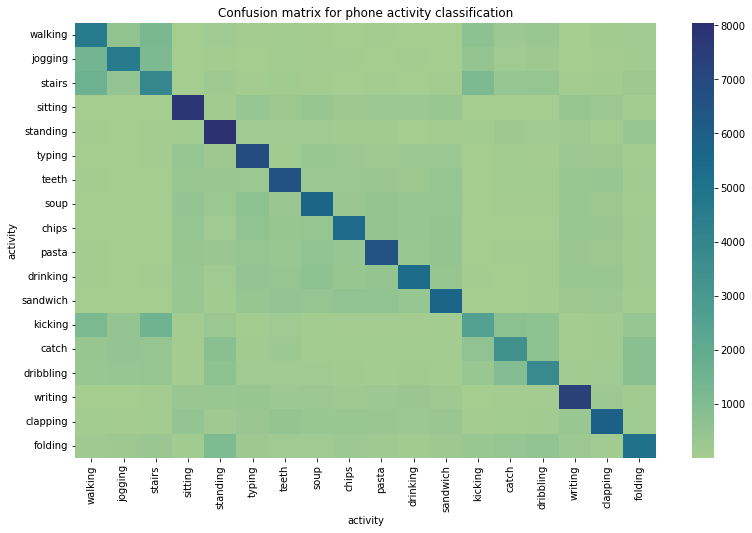

In [142]:
predictions = knn.predict(phone_x_test)
results = pd.DataFrame(confusion_matrix(phone_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

In [55]:
%%time
knn = KNeighborsClassifier(n_neighbors = 18, n_jobs = -1)
knn.fit(watch_x_train, watch_y_train)

CPU times: user 325 ms, sys: 0 ns, total: 325 ms
Wall time: 318 ms


KNeighborsClassifier(n_jobs=-1, n_neighbors=18)

In [56]:
%%time
knn.score(watch_x_test, watch_y_test)

CPU times: user 47min 59s, sys: 33min 30s, total: 1h 21min 29s
Wall time: 28min 58s


0.5613515799185054

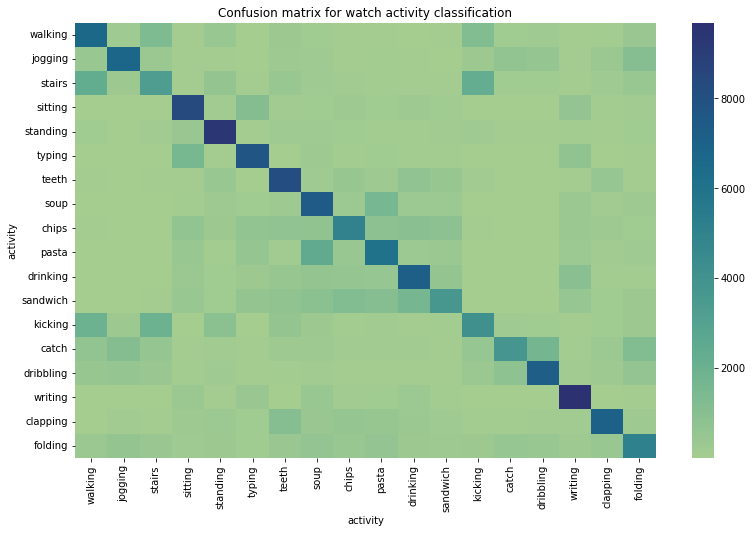

In [57]:
predictions = knn.predict(watch_x_test)
results = pd.DataFrame(confusion_matrix(watch_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for watch activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

### Navie Bayes

In [209]:
from sklearn.naive_bayes import GaussianNB

In [210]:
%%time
gnb = GaussianNB()
gnb.fit(phone_x_train, phone_y_train)

CPU times: user 434 ms, sys: 13.6 ms, total: 447 ms
Wall time: 420 ms


GaussianNB()

In [211]:
%%time
gnb.score(phone_x_test, phone_y_test)

CPU times: user 274 ms, sys: 5.26 ms, total: 280 ms
Wall time: 264 ms


0.16778890210653932

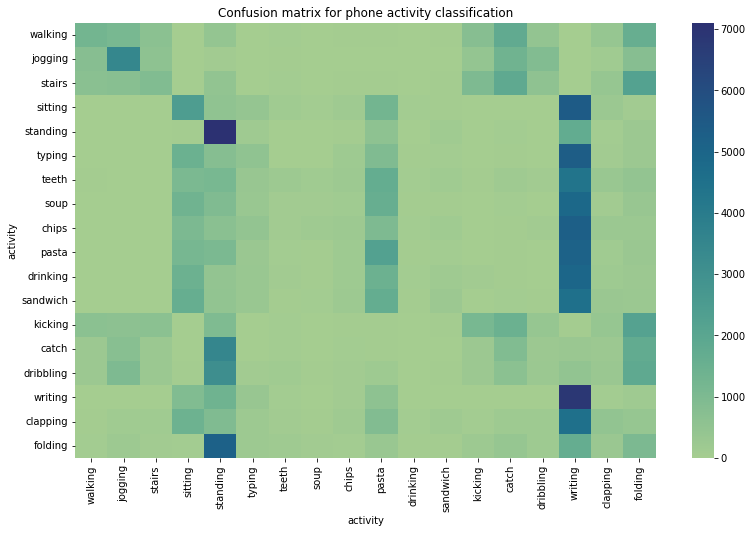

In [212]:
predictions = gnb.predict(phone_x_test)
results = pd.DataFrame(confusion_matrix(phone_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

In [213]:
%%time
gnb = GaussianNB()
gnb.fit(watch_x_train, watch_y_train)

CPU times: user 516 ms, sys: 13.2 ms, total: 529 ms
Wall time: 503 ms


GaussianNB()

In [214]:
%%time
gnb.score(watch_x_test, watch_y_test)

CPU times: user 339 ms, sys: 6.41 ms, total: 345 ms
Wall time: 320 ms


0.34704870454370723

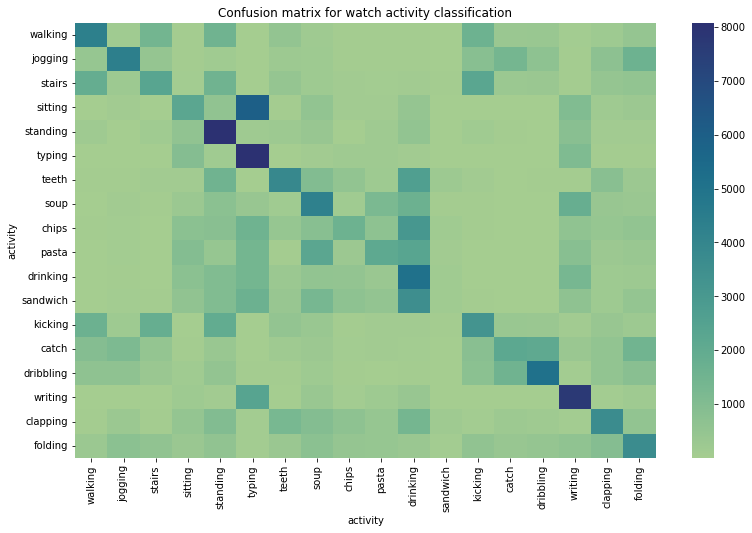

In [215]:
predictions = gnb.predict(watch_x_test)
results = pd.DataFrame(confusion_matrix(watch_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for watch activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

### Random Forest Classifier

In [216]:
from sklearn.ensemble import RandomForestClassifier

In [217]:
%%time
clf = RandomForestClassifier(min_samples_leaf=20, random_state=seed)
clf.fit(phone_x_train, phone_y_train)

CPU times: user 2min 15s, sys: 950 ms, total: 2min 16s
Wall time: 2min 9s


RandomForestClassifier(min_samples_leaf=20, random_state=23)

In [218]:
%%time
clf.score(phone_x_test, phone_y_test)

CPU times: user 3.71 s, sys: 41.8 ms, total: 3.75 s
Wall time: 3.56 s


0.7644671610953322

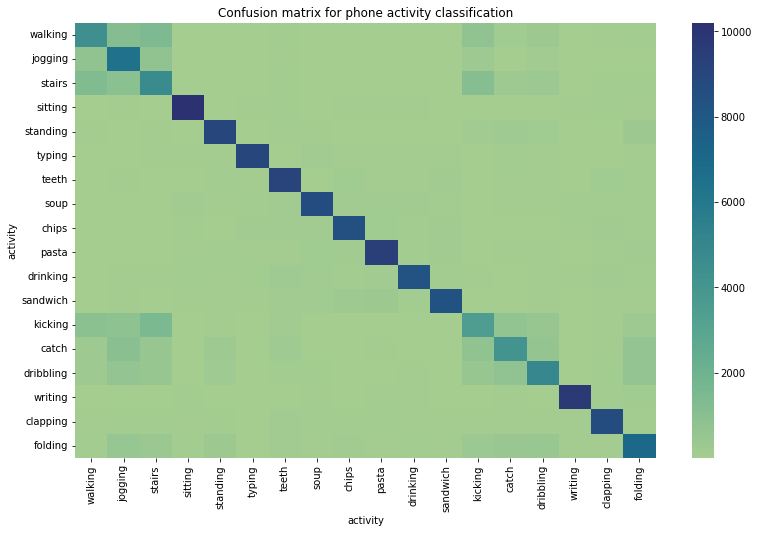

In [219]:
predictions = clf.predict(phone_x_test)
results = pd.DataFrame(confusion_matrix(phone_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

In [220]:
%%time
clf = RandomForestClassifier(min_samples_leaf=20, random_state=seed)
clf.fit(watch_x_train, watch_y_train)

CPU times: user 2min 46s, sys: 1.17 s, total: 2min 47s
Wall time: 2min 38s


RandomForestClassifier(min_samples_leaf=20, random_state=23)

In [221]:
%%time
clf.score(watch_x_test, watch_y_test)

CPU times: user 4.58 s, sys: 45.7 ms, total: 4.63 s
Wall time: 4.4 s


0.6285317521334666

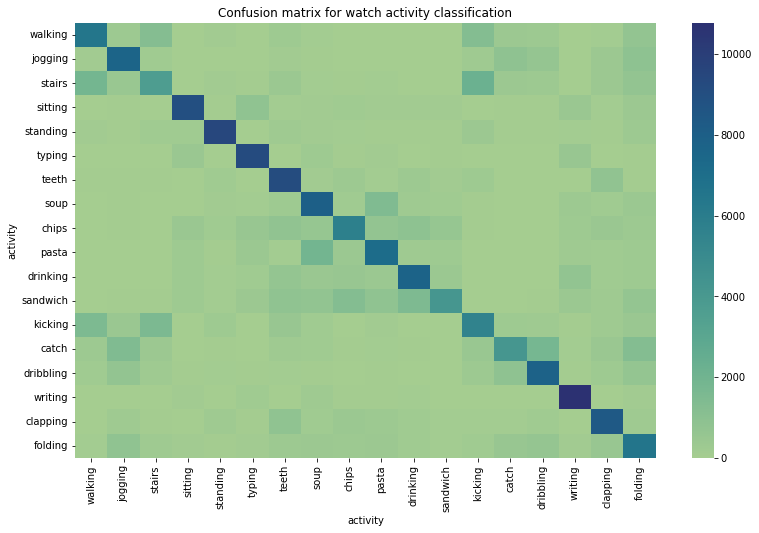

In [222]:
predictions = clf.predict(watch_x_test)
results = pd.DataFrame(confusion_matrix(watch_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for watch activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

### Decision Tree Classifier

In [223]:
from sklearn.tree import DecisionTreeClassifier

In [224]:
%%time
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(phone_x_train, phone_y_train)

CPU times: user 11.2 s, sys: 87.7 ms, total: 11.3 s
Wall time: 10.7 s


DecisionTreeClassifier(random_state=23)

In [225]:
%%time
clf.score(phone_x_test, phone_y_test)

CPU times: user 185 ms, sys: 4.83 ms, total: 189 ms
Wall time: 180 ms


0.7035306304819257

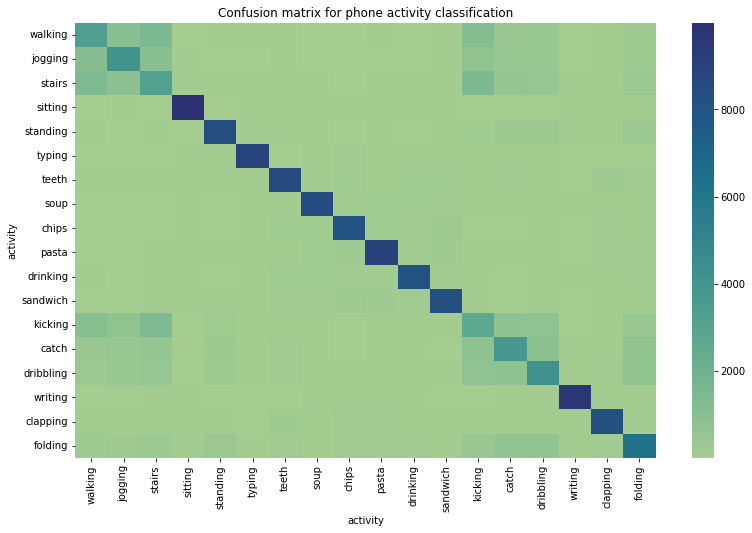

In [226]:
predictions = clf.predict(phone_x_test)
results = pd.DataFrame(confusion_matrix(phone_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

In [227]:
%%time
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(watch_x_train, watch_y_train)

CPU times: user 14.8 s, sys: 111 ms, total: 15 s
Wall time: 14.2 s


DecisionTreeClassifier(random_state=23)

In [228]:
%%time
clf.score(watch_x_test, watch_y_test)

CPU times: user 242 ms, sys: 6.21 ms, total: 249 ms
Wall time: 236 ms


0.5153715307142308

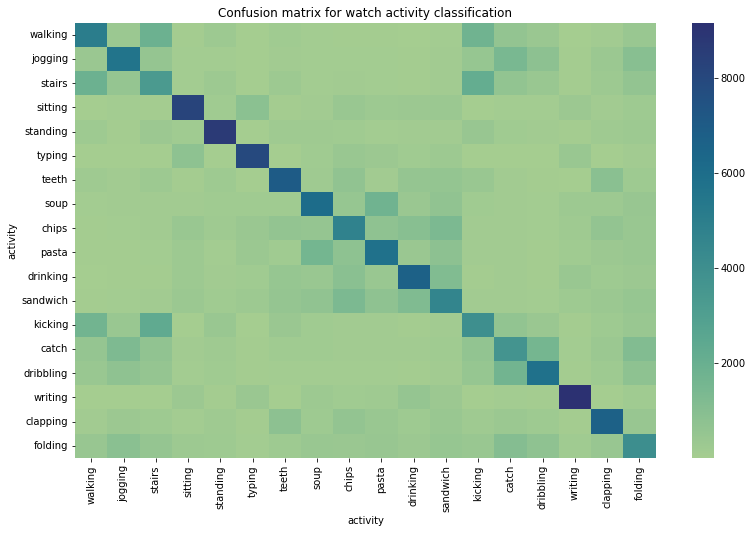

In [229]:
predictions = clf.predict(watch_x_test)
results = pd.DataFrame(confusion_matrix(watch_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for watch activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

### AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostClassifier

In [231]:
%%time
clf = AdaBoostClassifier(n_estimators=100, random_state=seed)
clf.fit(phone_x_train, phone_y_train)

CPU times: user 1min 55s, sys: 3.33 s, total: 1min 59s
Wall time: 1min 53s


AdaBoostClassifier(n_estimators=100, random_state=23)

In [232]:
%%time
clf.score(phone_x_test, phone_y_test)

CPU times: user 4.34 s, sys: 47.1 ms, total: 4.39 s
Wall time: 4.16 s


0.18822819609427915

In [233]:
%%time
staged_scores = [s for s in clf.staged_score(phone_x_test, phone_y_test)]

CPU times: user 18.1 s, sys: 542 ms, total: 18.7 s
Wall time: 17.8 s


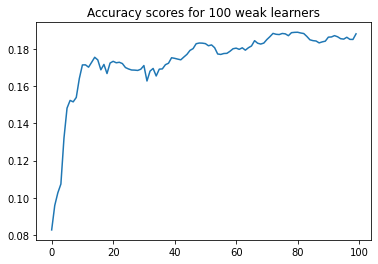

In [234]:
plt.title('Accuracy scores for 100 weak learners')
plt.plot((staged_scores))
plt.show()

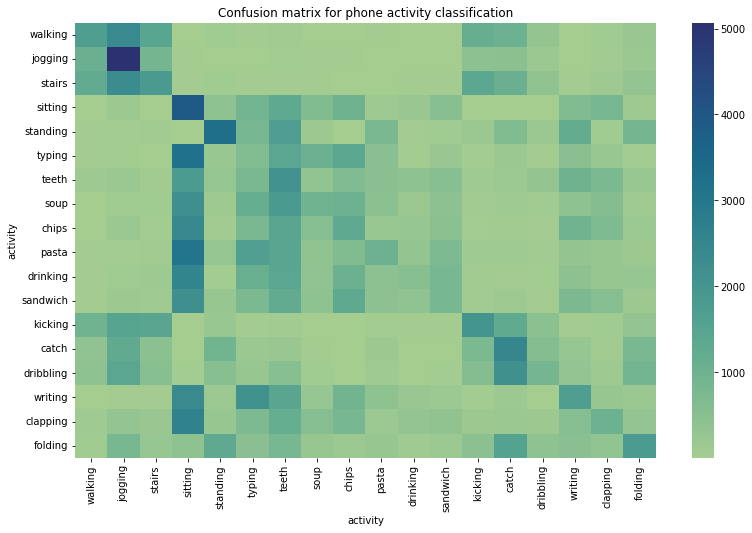

In [235]:
predictions = clf.predict(phone_x_test)
results = pd.DataFrame(confusion_matrix(phone_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for phone activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

In [62]:
%%time
clf = AdaBoostClassifier(n_estimators=100, random_state=seed)
clf.fit(watch_x_train, watch_y_train)

CPU times: user 2min 23s, sys: 3.1 s, total: 2min 26s
Wall time: 2min 21s


AdaBoostClassifier(n_estimators=100, random_state=23)

In [63]:
%%time
clf.score(watch_x_test, watch_y_test)

CPU times: user 5.03 s, sys: 40.3 ms, total: 5.07 s
Wall time: 4.89 s


0.3204764742061967

In [64]:
staged_scores = [s for s in clf.staged_score(phone_x_test, phone_y_test)]

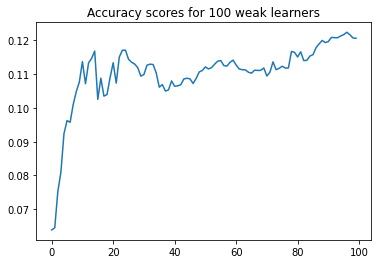

In [65]:
plt.title('Accuracy scores for 100 weak learners')
plt.plot((staged_scores))
plt.show()

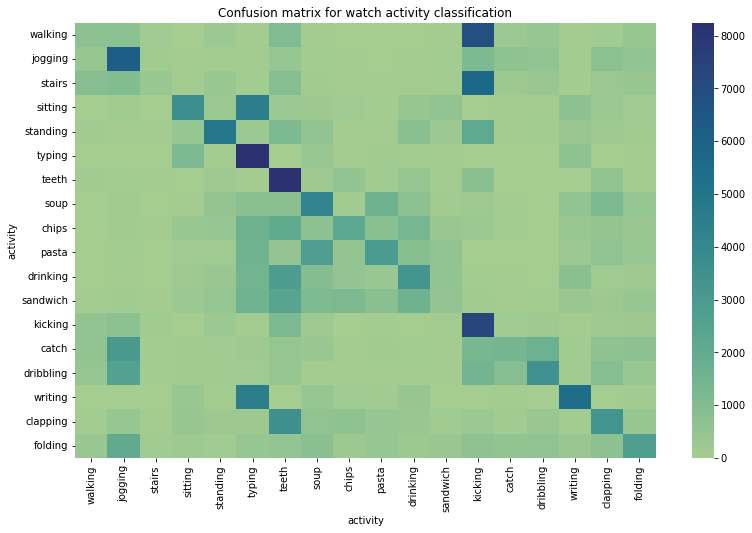

In [241]:
predictions = clf.predict(watch_x_test)
results = pd.DataFrame(confusion_matrix(watch_y_test, predictions, labels = activity_key['code']))
results.columns = activity_key['activity']
results.set_index(activity_key['activity'], drop = False, inplace=True) 
plt.figure(figsize = (13,8))
plt.title('Confusion matrix for watch activity classification')
sns.heatmap(results, cmap = 'crest')
plt.show()

### Desc Tree class

In [60]:
# TRAIN TEST SPLIT

#df = grouped_phone_df
df = dd.from_pandas(grouped_phone_df, npartitions=1)

# split off labels
#feat_cols = ['x', 'y', 'z']
label_col = ['code']

feature_df = df[feat_cols]
label_df = df[label_col]

X_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, shuffle=True, random_state=seed)

In [61]:
# SCALE DATA

# instatiate scaler
scaler = StandardScaler()
# fit the scaler
scalerModel = scaler.fit(X_train)
# scale the training data
X_train_scaled = scalerModel.transform(X_train)
# scale the test data
X_test_scaled = scalerModel.transform(x_test)

In [62]:
# set up grid search parameters
param_grid = {'max_depth'        : list(range(1, 10)), # play around with max depth
              'min_samples_split': list(range(2, 10)), # must start at 2+
              'criterion'        : ['gini','entropy'],
             }

# <font color='red'>this is where it blows up</font>

In [63]:
stop

NameError: name 'stop' is not defined

In [ ]:
# GRID SEARCH

# instantiate base model
dt_model = DecisionTreeClassifier(random_state=seed)

# istantiate grid search object
dt_model_grid_dask = dcv.GridSearchCV(dt_model, param_grid, cv=10)

# execute grid search
'''
does this need joblib backend if we are using native dask?
'''
with joblib.parallel_backend("dask"):
    dt_model_grid_dask.fit(X_train_scaled, y_train)

In [ ]:
best_params = dt_model_grid_dask.best_params_
print(best_params)

In [ ]:
print(dt_model_grid_dask.best_score_)

In [ ]:
# now that we've performed a gridsearch, use parameters from out best model

# instantiate best model
best_dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    criterion=best_params['criterion'],
    random_state=seed
)

# fit model to training data
'''
does this need joblib backend if we are using native dask?
'''
with joblib.parallel_backend("dask"):
    best_dt_model.fit(X_train_scaled, y_train)

# check accuracy from this model on test data
best_dt_model.score(X_test_scaled, y_test)

## Analysis results

## Challenges & solutions

## Insights gained

## Future work

## References

1. Dask vs spark picture: https://medium.datadriveninvestor.com/pandas-dask-or-pyspark-what-should-you-choose-for-your-dataset-c0f67e1b1d36
2. Accelerometer information https://en.wikipedia.org/wiki/Accelerometer
3. Gyroscope Information https://en.wikipedia.org/wiki/Gyroscope

In [42]:
# always close client connection at end of workflow
client.shutdown()